Installing necessary packages

In [1]:
!pip install torch torchvision matplotlib scikit-learn seaborn

Importing libraries and checking GPU availibility

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import os

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [31]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raomuhammaddayanatif","key":"90ac889e0f9c5c16cfe8df4d54075af7"}'}

In [32]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Downloading dataset from kaggle

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.28G/2.29G [00:51<00:02, 4.64MB/s]
100% 2.29G/2.29G [00:51<00:00, 48.1MB/s]


In [33]:
!unzip -q chest-xray-pneumonia.zip -d /content/
!ls /content/chest_xray


replace /content/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: chest_xray  __MACOSX  test  train  val


Setting paths

In [34]:
# Fixed dataset paths
train_dir = "./data/chest_xray/train"
val_dir   = "./data/chest_xray/val"
test_dir  = "./data/chest_xray/test"

# In case of nested folder issue
if not os.path.exists(train_dir):
    train_dir = "./data/chest_xray/chest_xray/train"
    val_dir   = "./data/chest_xray/chest_xray/val"
    test_dir  = "./data/chest_xray/chest_xray/test"

print("Train path:", train_dir)
print("Val path:", val_dir)
print("Test path:", test_dir)


Train path: ./data/chest_xray/chest_xray/train
Val path: ./data/chest_xray/chest_xray/val
Test path: ./data/chest_xray/chest_xray/test


In [35]:
# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("./chest_xray/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder("./chest_xray/val", transform=test_transforms)
test_dataset  = datasets.ImageFolder("./chest_xray/test", transform=test_transforms)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)


Classes: ['NORMAL', 'PNEUMONIA']


Dsiplay sample image

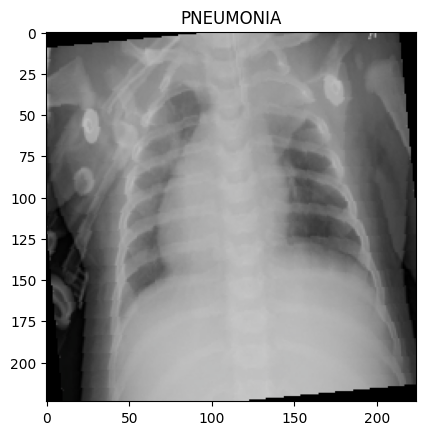

In [36]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()

# Show a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(images[0], title=class_names[labels[0]])


Initializing model

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

# Freeze earlier layers
for param in model.parameters():
    param.requires_grad = False

# Modify classifier for 2 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)
print(model)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Initializing CrossEntropy and Optimizer

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


Training

In [39]:
from torch.optim.lr_scheduler import StepLR

def evaluate(model, criterion, loader):
    model.eval()
    loss = 0
    correct = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    return loss/len(loader), 100. * correct / len(loader.dataset)

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10, patience=3):
    history = {"train_loss": [], "val_loss": [], "val_acc": []}
    scheduler = StepLR(optimizer, step_size=2, gamma=0.1) # Learning rate scheduler
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        val_loss, val_acc = evaluate(model, criterion, val_loader)

        history["train_loss"].append(running_loss/len(train_loader))
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print("Early stopping!")
                break

        scheduler.step() # Step the scheduler

    return history

history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10, patience=3)

Epoch 1/10, Train Loss: 0.3328, Val Loss: 0.2887, Val Acc: 93.75%
Epoch 2/10, Train Loss: 0.1924, Val Loss: 0.3251, Val Acc: 81.25%
Epoch 3/10, Train Loss: 0.1681, Val Loss: 0.3489, Val Acc: 75.00%
Epoch 4/10, Train Loss: 0.1593, Val Loss: 0.2855, Val Acc: 81.25%
Epoch 5/10, Train Loss: 0.1643, Val Loss: 0.3009, Val Acc: 81.25%
Epoch 6/10, Train Loss: 0.1552, Val Loss: 0.3458, Val Acc: 75.00%
Epoch 7/10, Train Loss: 0.1576, Val Loss: 0.3350, Val Acc: 75.00%
Early stopping!


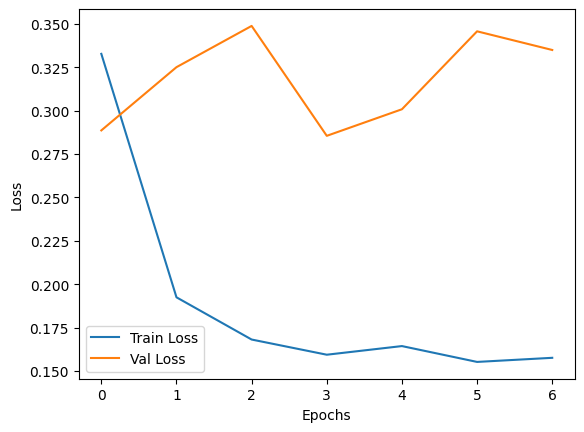

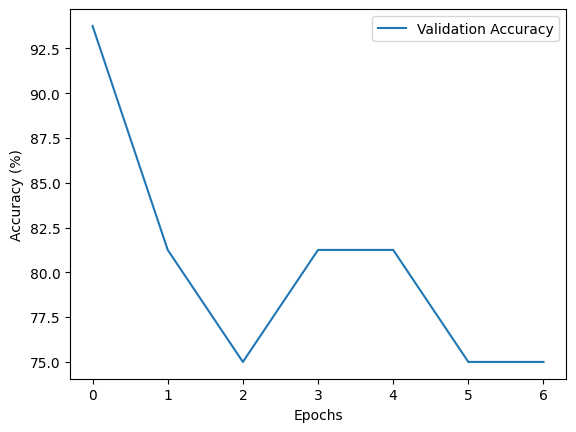

In [40]:
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()


In [41]:
test_loss, test_acc = evaluate(model, criterion, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Test Loss: 0.2869, Test Accuracy: 89.74%


**PREDICTIONS**

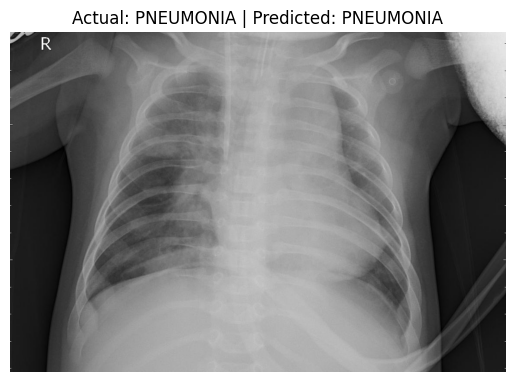

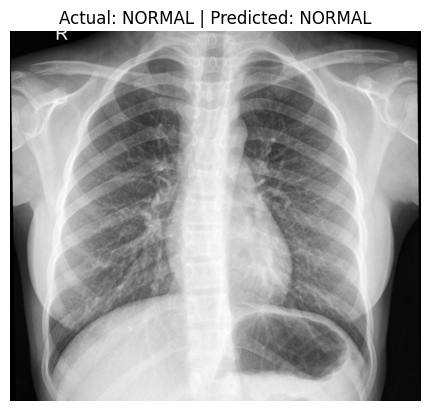

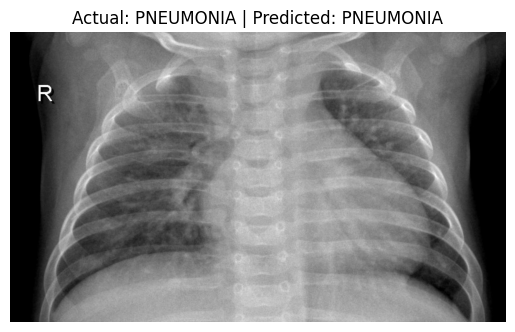

In [46]:
def predict_image(image_path):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = test_transforms
    img = transform(image).unsqueeze(0).to(device)

    # Get actual label from path (folder name)
    actual_label = os.path.basename(os.path.dirname(image_path))

    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
        predicted_label = class_names[pred]

    plt.imshow(image)
    plt.title(f"Actual: {actual_label} | Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

# Example prediction
predict_image("chest_xray/test/PNEUMONIA/person104_bacteria_491.jpeg")
predict_image("chest_xray/test/NORMAL/IM-0033-0001-0001.jpeg")
predict_image("/content/chest_xray/test/PNEUMONIA/person121_bacteria_580.jpeg")
